In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from numpy import asarray
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder
%matplotlib inline 

In [2]:
# Bounding Box Visualization pre-requesite

DATA_FOLDER = '../data/'

num_classes = 3

cloud_class_id = 0
water_class_id = 1
ground_class_id = 2

category_index = {
  cloud_class_id: {'id': cloud_class_id, 'name': 'cloud'},
  water_class_id: {'id': water_class_id, 'name': 'water'},
  ground_class_id: {'id': ground_class_id, 'name': 'ground'},
}

label_2_category = {'cloud':0,'water':1,'ground':2}

width, heigth = (2592, 1944) # these dimension are from astro pi default image

In [3]:
def load_image_into_numpy_array(path):

  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
 
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.title(image_name)
    plt.imshow(image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

# Parsing XML annotation

In [4]:
import xml.etree.ElementTree as ET

# Get Image Annotation from XML Pascal VOC file
def get_img_annotations(img_xml_annotations_path):
  img_tree = ET.parse(img_xml_annotations_path)
  img_root = img_tree.getroot()
  labels_list = []
  bbox_list = []
  for child in img_root:
    if child.tag == "object":
      for element in child:
        if element.tag == "name":
          labels_list.append(element.text)
        if element.tag == "bndbox":
          bbox = []
          for coordinates in element:
            if coordinates.tag == "xmin":
              bbox.append(coordinates.text)
            if coordinates.tag == "ymin":
              bbox.append(coordinates.text)
            if coordinates.tag == "xmax":
              bbox.append(coordinates.text)
            if coordinates.tag == "ymax":
              bbox.append(coordinates.text)
          bbox_list.append(bbox)
  return labels_list, bbox_list

In [5]:
# Prepare Bounding Box so that it is normalized & invariant from image scale dimension
def get_prepared_bbox(bbox, width, heigth):
  for coord in bbox:
    xmin_norm=int(bbox[0])/width
    ymin_norm=int(bbox[1])/heigth
    xmax_norm=int(bbox[2])/width
    ymax_norm=int(bbox[3])/heigth
  prepared_bbox = [ymin_norm,xmin_norm,ymax_norm,xmax_norm] # Object Detection Viz utils expected format
  return prepared_bbox

# Data Prepaparation for Inference

In [6]:
# Get name of astropi Jpeg images
def get_images_name(data_folder):
  data = os.listdir(data_folder)
  images_file_list = [file for file in data if os.path.splitext(file)[1] != '.xml'] # remove xml file
  images_file_list.sort()
  return images_file_list

# Get name of astropi XML annotations
def get_bboxes_file_name(data_folder):
  data = os.listdir(data_folder)
  bbox_file_list = [file for file in data if os.path.splitext(file)[1] != '.jpg']
  bbox_file_list.sort()
  return bbox_file_list

# Get a List of astropi numpy images
def get_numpy_images(images_file,data_folder):
  np_images_list = []
  for image_file in images_file:
    img_pil = Image.open(data_folder+image_file)
    img_np = asarray(img_pil)
    np_images_list.append(img_np)
  return np_images_list

# Get a List of bboxes & classes for images
def get_gt_box_class(bbox_file_list,data_folder):
  gt_boxes_list = []
  classes_list = []
  for bboxes in bbox_file_list: 
    classes,gt_boxes=get_img_annotations(data_folder+bboxes)
    gt_boxes_np = np.array(gt_boxes,dtype=np.float32)
    gt_boxes_list.append(gt_boxes_np)
    classes_list.append(classes)
  return gt_boxes_list, classes_list
  
# Get a List of class_id for images
def get_class_id(classes_list): 
  classes_id_list = []
  for classes in classes_list:
    id_list  = []
    for label in classes:
      id = label_2_category[label]
      id_list.append(id)
    classes_id_list.append(id_list)
  return classes_id_list

In [7]:
# Grab Data from raw JPEG & XML files to lists
images_list = get_images_name(DATA_FOLDER)
np_images_list = get_numpy_images(images_list,DATA_FOLDER)
bboxes_file_list = get_bboxes_file_name(DATA_FOLDER)
gt_boxes_list, classes_list = get_gt_box_class(bboxes_file_list,DATA_FOLDER)
classes_id_list = get_class_id(classes_list)

# Inference from SavedModel

In [8]:
# Prepare Data for Training: convert all numpy arrays & lists to TF tensors

def get_tensors_data(np_images_list,gt_boxes_list,classes_id_list):
    image_tensors = [] # images tensor list from numpy array
    gt_box_tensors = [] # bbox tensor list from gt_box list
    class_one_hot_tensors = [] # 1-hot class tensor list from class list

    for (image_np, gt_box_np,class_id) in zip(np_images_list, gt_boxes_list,classes_id_list):
        image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
            image_np, dtype=tf.float32), axis=0))
        gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
        indexed_classes = tf.convert_to_tensor(class_id,dtype=tf.int32)
        class_one_hot_tensors.append(tf.one_hot(
            indexed_classes, num_classes))
    print('Done prepping data.')
    return image_tensors,gt_box_tensors,class_one_hot_tensors

In [9]:
# Training Data
image_tensors,gt_box_tensors,class_one_hot_tensors = get_tensors_data(np_images_list,gt_boxes_list,classes_id_list)

2022-02-17 16:22:46.886108: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Done prepping data.


In [10]:
# Load savedModel
tf.keras.backend.clear_session()
model = tf.saved_model.load('../training/export/saved_model')
model_fn = model.signatures['serving_default']

In [11]:
def get_resized_img(size_tuple,img_tensor):
    resized_img = tf.image.resize(
        img_tensor, size_tuple, preserve_aspect_ratio=False,
        antialias=False, name=None
    )
    resized_img = tf.cast(resized_img,dtype=tf.uint8)
    return resized_img

def get_pad_resized_img(size,img_tensor):
    resized_img = tf.image.resize_with_pad(
        img_tensor, size,size,
        antialias=False
    )
    resized_img = tf.cast(resized_img,dtype=tf.uint8)
    return resized_img

In [12]:
def get_predictions(image_name):
  image_path = DATA_FOLDER+image_name+'.jpg'
  image = Image.open(image_path)
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]
  input_tensor = get_pad_resized_img(320,input_tensor)
  output_dict = model_fn(input_tensor)
  return output_dict
  

def get_prediction_bboxes(image_name):
  image_path = DATA_FOLDER+image_name+'.jpg'
  image = Image.open(image_path)
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]
  input_tensor = get_pad_resized_img(320,input_tensor)
  output_dict = model_fn(input_tensor)
  bboxes = output_dict['detection_boxes'].numpy()
  return bboxes[0]


def get_prediction_classes(image_name):
  image_path = DATA_FOLDER+image_name+'.jpg'
  image = Image.open(image_path)
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]
  input_tensor = get_pad_resized_img(320,input_tensor)
  output_dict = model_fn(input_tensor)
  classes = output_dict['detection_classes'].numpy()
  return classes[0]


def get_prediction_scores(image_name):
  image_path = DATA_FOLDER+image_name+'.jpg'
  image = Image.open(image_path)
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]
  input_tensor = get_pad_resized_img(320,input_tensor)
  output_dict = model_fn(input_tensor)
  classes = output_dict['detection_scores'].numpy()
  return classes[0]


def get_predictions_all(image_name):
  image_path = DATA_FOLDER+image_name+'.jpg'
  image = Image.open(image_path)
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]
  input_tensor = get_pad_resized_img(320,input_tensor)
  output_dict = model_fn(input_tensor)
  bboxes = output_dict['detection_boxes'].numpy()
  classes = output_dict['detection_classes'].numpy()
  scores = output_dict['detection_scores'].numpy()
  return bboxes,classes,scores

In [13]:
# Get raw image prediction 
img = 'zz_astropi_1_photo_189'
predictions = get_predictions(img)
prediction_bboxes = get_prediction_bboxes(img)
prediction_classes = get_prediction_classes(img)
prediction_scores = get_prediction_scores(img)
object_nb = prediction_bboxes.shape[1]

In [14]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
 
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    #plt.imsave(image_name, image_np_with_annotations)
    plt.title(image_name)
    plt.imshow(image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [15]:
def get_image_with_annotation(image_name):
  image_file = image_name + '.jpg'
  xml_file = image_name + '.xml'
  image = Image.open(DATA_FOLDER+image_file)
  image_np = asarray(image)
  labels, bboxes = get_img_annotations(DATA_FOLDER+xml_file) # get Labels + Bounding Boxes

  # Prepared bbox as expected by Object Detection Viz utils
  prepared_bboxes = [] 
  for bbox in bboxes:
    prepared_bbox = get_prepared_bbox(bbox,width,heigth)
    prepared_bboxes.append(prepared_bbox)

  gt_box = np.array(prepared_bboxes, dtype=np.float32)

  # plot_detections parameters
  image_np_with_annotations = image_np.copy()
  boxes = gt_box
  class_list = []
  for label in labels:
    class_list.append(label_2_category[label])
  classes = np.array(class_list,dtype=np.int32)
  scores = np.array([1.0]*len(labels), dtype=np.float32)

  # Plotting detection
  plot_detections(
    image_np_with_annotations,
    boxes,
    classes,
    scores,
    category_index,
    image_name
    )

In [16]:
# Visualize Images with XML annotation prepared
def get_image_with_predictions(image_name):
  image_file = image_name + '.jpg'
  image = Image.open(DATA_FOLDER+image_file)
  image_np = asarray(image)

  gt_box = get_prediction_bboxes(image_name)
  classes = get_prediction_classes(image_name)

  # plot_detections parameters
  image_np_with_annotations = image_np.copy()
  boxes = gt_box
  class_list = []
  for label in classes:
    class_list.append(int(label))
  classes = np.array(class_list,dtype=np.int32)
  scores = np.array([1.0]*gt_box.shape[0], dtype=np.float32)

  # Plotting detection
  plot_detections(
    image_np_with_annotations,
    boxes,
    classes,
    scores,
    category_index,
    image_name
    )

In [17]:
i = 'zz_astropi_1_photo_189'
compare_images = [i,i]

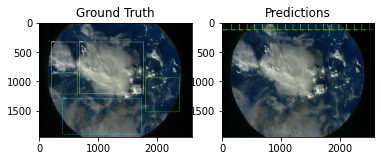

In [18]:
for idx, image in enumerate(compare_images):
  plt.subplot(1, 2, idx+1)
  if idx == 0:
    plt.title('Ground Truth')
    get_image_with_annotation(image)
  elif idx == 1:
    plt.title('Predictions')
    get_image_with_predictions(image)
plt.show()

# Inference from TFLite

In [51]:
tflite_model_path  = '../training/tflite/model.tflite'

In [52]:
def get_tflite_prepared_image(image_name):
  image_file = image_name + '.jpg'
  img_pil = Image.open(DATA_FOLDER+image_file)
  img_np = asarray(img_pil)
  img_tensor = tf.expand_dims(tf.convert_to_tensor(
    img_np, dtype=tf.float32), axis=0)
  preprocessed_img =  get_pad_resized_img(320,img_tensor)
  return preprocessed_img

In [53]:
def get_tflite_predictions(image_name,tflite_interpreter):
  # Prepare image
  preprocessed_img = get_tflite_prepared_image(image_name)
  input_tensor = preprocessed_img
  input_tensor = tf.cast(input_tensor,dtype=tf.float32)
  image_tflite_np = input_tensor.numpy()


  input_details = tflite_interpreter.get_input_details()
  output_details = tflite_interpreter.get_output_details() 

  # Prepare data for TFLite inference
  input_shape = input_details[0]['shape'] # tflite model input shape
  input_data = image_tflite_np.reshape(input_shape) # tflite model input data as numpy

  # This load input_data into tlfite interpreter
  interpreter.set_tensor(input_details[0]['index'], input_data)
  interpreter.invoke()

  # All useful Data from tflite inference: boxes, classes, scores
  boxes = interpreter.get_tensor(output_details[1]['index'])
  classes = interpreter.get_tensor(output_details[3]['index'])
  scores = interpreter.get_tensor(output_details[0]['index'])

  return boxes, classes, scores

In [62]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get Prediction
boxes, classes, scores =  get_tflite_predictions(img,interpreter)

In [55]:
def post_process_df_prediction(prediction):
  prediction_list = []
  columns = ['ymin','xmin','ymax','xmax']
  prediction_df = pd.DataFrame(prediction[0][0],columns=columns)
  prediction_df['class'] = prediction[1][0].astype(np.int8)
  prediction_df['score'] = prediction[2][0]
  for index, row in prediction_df.iterrows():
    prediction_list.append(list(row))
  return prediction_list

In [56]:
def post_process_prediction(prediction):
  prediction_dico_list = []
  i  = 0 
  for (bbox,classe,score) in zip(prediction[0][0],prediction[1][0],prediction[2][0]):
    prediction_dico = {'id':i,'ymin':bbox[0],'xmin':bbox[1],'ymax':bbox[2],'xmax':bbox[3],'class':classe,'score':score}
    prediction_dico_list.append(prediction_dico)
    i = i+1
  return prediction_dico_list

In [63]:
prediction = get_tflite_predictions(img,interpreter)
post_proc_prediction = post_process_prediction(prediction)

In [ ]:
for e in post_proc_prediction:
  print(e)